## Loading modules and checking device
First, we will load our libraries and check which device we are using, we would prefer using cuda for faster training

In [1]:
import os
import re
import sys
import glob
import numpy as np
import matplotlib.pyplot as plt
import unittest
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as tvtf
import json
import RandomProjection as RP

%matplotlib inline
%load_ext autoreload
%autoreload 2

seed = 318
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
plt.rcParams.update({'font.size': 12})
test = unittest.TestCase()
device

device(type='cpu')

## Importing Datasets
Now we will download our different datasets, MNIST, CIFAR-10, CIFAR-100 etc..

*MNIST Download*

Train: 60000 samples
Test: 60000 samples
MNIST input image size = torch.Size([1, 28, 28])
5


torch.Size([32, 784])

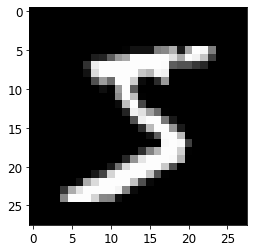

In [2]:
#MNIST DOWNLOAD
data_dir = os.path.expanduser('~/.pytorch-datasets')
mnist_train = torchvision.datasets.MNIST(root=data_dir, download=True, train=True, transform=tvtf.ToTensor())
mnist_train_matrix = RP.get_dataset_matrix(mnist_train)
mnist_test = torchvision.datasets.MNIST(root=data_dir, download=True, train=False, transform=tvtf.ToTensor())
#Create BucketIterator for dataset
batch_size = 32

mdl_train = torch.utils.data.DataLoader(mnist_train, batch_size, shuffle=True)
mdl_test = dl_train = torch.utils.data.DataLoader(mnist_test, batch_size, shuffle=True)


print(f'Train: {len(mnist_train)} samples')
print(f'Test: {len(mnist_train)} samples')

x0,y0 = mnist_train[0]
in_size = x0.shape
num_classes = 10
print('MNIST input image size =', in_size)
print(y0)
def to_image(x):
    return (x * torch.ones(3,28,28)).permute(1,2,0)
plt.imshow(to_image(x0))

X,y = next(iter(mdl_train))
X = X.reshape(X.size(0), -1) 
X.shape

## Loading the model
We will now load the Linear Classifier model and test it's output

In [3]:
from LinearNetwork import LinearClassifier as FCModel
mnist_model = FCModel(in_size=784, out_classes=10, activation_type="relu", hidden_dims=[64,32])
mnist_model = mnist_model.to(device)

mnist_model

LinearClassifier(
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=10, bias=True)
    (5): Softmax(dim=1)
  )
)

## Performing experiments on the model
We will perform training on the original architecture persented at: https://arxiv.org/pdf/1812.09489.pdf on MNIST dataset, and other datasets with more features, we would later train and evaluate on the a new presented architecture.

In [4]:
# We will try two main architectures, both with RP layer at first,
# it is a Linear layer which does not train and it's weights are
# a RP matrix from our implemented module for Random Projection

from Trainer import train_and_eval, present_accuracy, print_stats
# we will try varying projected dimension k for the MNIST problem
#experiment on different k's
def count_parameters(model): return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [5]:
#This code block saves results from our results data format, can put in a function
def Save_Results(results, rp_type, verbose=False, dataset="MNIST"):
    if verbose is True:
        for k in results.keys():
            print(f"Projected:{k}: train accuracy:{max(results[k][0])}, test accuracy:{max(results[k][1])}")

    file = open(f"Results/{dataset}_RP_{rp_type}.txt","w")
    file.write(json.dumps(results))
    file.close()

**Loading**<br/>We will load the results from files and in that case we would not retrain

In [6]:
projections = ["Gaussian","Achlioptas", "Li", "CountSketch", "SRHT", "PCA"] 
results = {}
for proj in projections:
    if not os.path.isfile(f"Results/MNIST_RP_{proj}.txt"):
        continue
    file = open(f"Results/MNIST_RP_{proj}.txt","r+")
    results[proj] = json.loads(file.read())
    file.close()

In any other case we retrain

We will also calculate the PCA of the dataset first

In [7]:
A = mnist_train_matrix
U,S,V = torch.pca_lowrank(A,min(A.shape))

In [8]:
krange = torch.logspace(1,9,9,base=2) #we test k's from 1 to 784 with multiplicative steps of 2
padding = 0
for proj in projections:
    if proj in results.keys(): #We would not retrain any model alreay trained (if krange list changed we would want to retrain)
        print(f"loaded for {proj}")
        continue
    results[proj] = {}
    print(f"training for {proj}")
    if proj == "SRHT":
        padding = 1024-784 #TODO: make this line adaptive for input size
    else:
        padding = 0
    for k in list(krange)[::1]:
        if proj == "PCA":
             mnist_model = FCModel(in_size=784, out_classes=10, activation_type="relu", hidden_dims=[int(k/2)], rp=-1, rp_type=proj, padding=padding, pca=V[:,:int(k)].T).to(device)
        else:
            mnist_model = FCModel(in_size=784, out_classes=10, activation_type="relu", hidden_dims=[int(k/2)], rp=int(k), rp_type=proj, padding=padding).to(device)
        print(f"projected dimension:{int(k)}")
        #print(f"Model Architecture:{mnist_model}")
        lr = 1e-3
        optimizer = torch.optim.Adam(mnist_model.parameters(), lr=lr)
        loss_fn = nn.CrossEntropyLoss().to(device)

        res = train_and_eval(mnist_model, mdl_train, mdl_test, optimizer, loss_fn, verbose=True)
        results[proj][str(int(k))] = res

loaded for Gaussian
loaded for Achlioptas
loaded for Li
loaded for CountSketch
loaded for SRHT
loaded for PCA


**We will save the results to a txt file**

In [9]:
for proj in projections:
    print(proj)
    Save_Results(results[proj], proj)

Gaussian
Achlioptas
Li
CountSketch
SRHT
PCA


## Stats
We will now show the stats the best model for certain k values

In [ ]:
kvalues = [16,32,64]
for k in kvalues:
    model = FCModel(in_size=784, out_classes=10, activation_type="relu", hidden_dims=[int(k/2)], rp=int(k), rp_type="CountSketch", padding=0).to(device)
    lr = 1e-3
    optimizer = torch.optim.Adam(mnist_model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss().to(device)

    res = train_and_eval(mnist_model, mdl_train, mdl_test, optimizer, loss_fn, verbose=False)
    
    present_accuracy(model, mdl_test, classes=10)
    print_stats(model, mdl_test, classes=10)

## Graphs
Showing the results for different projection dimensions

For each Random Projection, we will display the best result in each measured parameter (i.e train and test loss and accuracy)

In [10]:
final = {}
for proj in results.keys():
    final[proj] = {}
    for k in results[proj].keys():
        for i in range(4): # 4 different measurements of accuracy/loss
            temp = max(results[proj][k][i]) if i <= 1 else min(results[proj][k][i])
            if i in final[proj].keys():
                final[proj][i].append(temp)
            else:
                final[proj][i] = [temp]
            
krange = torch.logspace(1,9,9,base=2) #we test k's from 1 to 784 with multiplicative steps of 2

In [11]:
from matplotlib.ticker import MaxNLocator
def plot_results(results, arr, label="k", xscale="linear", xbase=2.0): #results- list of results from different models, each result is a list
    colors = ["red","blue","green","black","yellow", "purple"]
    fig,_ = plt.subplots(nrows=2,ncols=2,sharex=True, figsize = (18,12))
    k = [int(i) for i in arr]
    for i, plot_type in enumerate(('train_acc', 'train_loss', 'valid_acc', 'valid_loss')):
        ax = fig.axes[i]
        if xscale == "log":
            ax.set_xscale(xscale, base=xbase)
        if xscale == "linear":
            ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        ax.set_yscale("linear")
        models_res = results[plot_type]
        idx = 0
        for model in models_res.keys():
            ax.plot(np.array(k), models_res[model], label=model, color=colors[idx])
            idx += 1
        ax.set_title(plot_type)
        ax.set_xlabel(label)
        ax.legend()
    return fig

In [12]:
len(results["Li"]["32"][3])

20

In [13]:
final.keys()

dict_keys(['Gaussian', 'Achlioptas', 'Li', 'CountSketch', 'SRHT', 'PCA'])

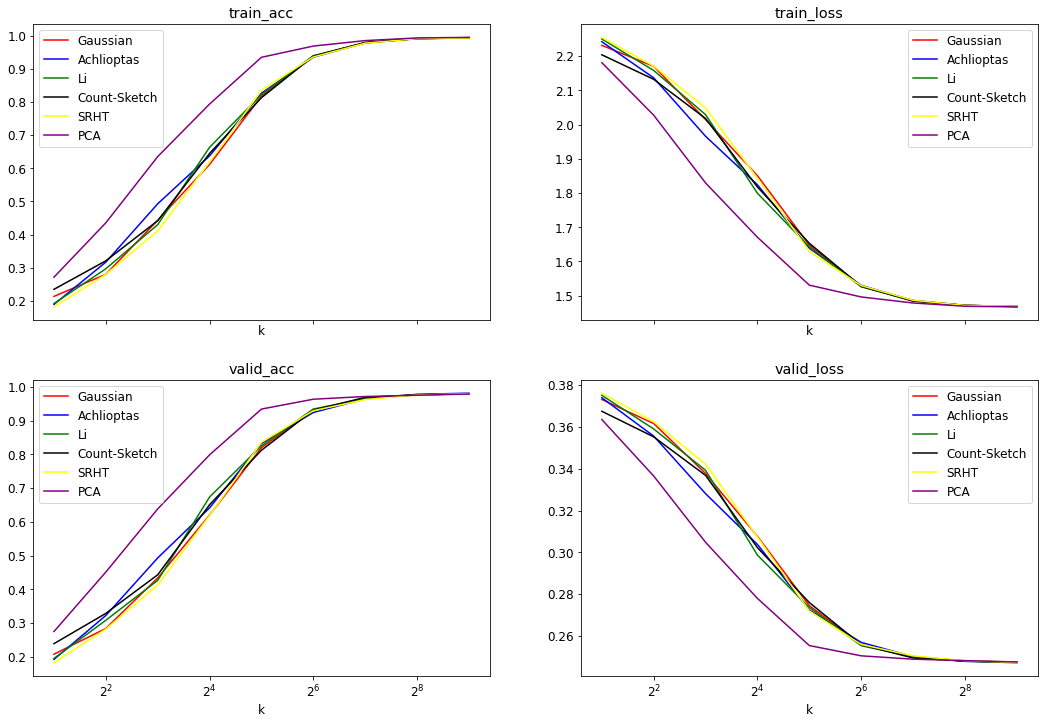

In [14]:
results_m = {'train_acc':None,'valid_acc':None,'train_loss':None,'valid_loss':None}
#graphs without pca
##results_m['train_acc'] = {'Gaussian':final["Gaussian"][0],'Achlioptas':final["Achlioptas"][0],'Li':final["Li"][0], "Count-Sketch": final["CountSketch"][0], "SRHT": final["SRHT"][0]}
##results_m['valid_acc'] = {'Gaussian':final["Gaussian"][1],'Achlioptas':final["Achlioptas"][1],'Li':final["Li"][1], "Count-Sketch": final["CountSketch"][1], "SRHT": final["SRHT"][1]}
##results_m['train_loss'] = {'Gaussian':final["Gaussian"][2],'Achlioptas':final["Achlioptas"][2],'Li':final["Li"][2], "Count-Sketch": final["CountSketch"][2], "SRHT": final["SRHT"][2]}
##results_m['valid_loss'] = {'Gaussian':final["Gaussian"][3],'Achlioptas':final["Achlioptas"][3],'Li':final["Li"][3], "Count-Sketch": final["CountSketch"][3], "SRHT": final["SRHT"][3]}
#graphs with pca
results_m['train_acc'] = {'Gaussian':final["Gaussian"][0],'Achlioptas':final["Achlioptas"][0],'Li':final["Li"][0], "Count-Sketch": final["CountSketch"][0], "SRHT": final["SRHT"][0],"PCA":final["PCA"][0]}
results_m['valid_acc'] = {'Gaussian':final["Gaussian"][1],'Achlioptas':final["Achlioptas"][1],'Li':final["Li"][1], "Count-Sketch": final["CountSketch"][1], "SRHT": final["SRHT"][1],"PCA":final["PCA"][1]}
results_m['train_loss'] = {'Gaussian':final["Gaussian"][2],'Achlioptas':final["Achlioptas"][2],'Li':final["Li"][2], "Count-Sketch": final["CountSketch"][2], "SRHT": final["SRHT"][2],"PCA":final["PCA"][2]}
results_m['valid_loss'] = {'Gaussian':final["Gaussian"][3],'Achlioptas':final["Achlioptas"][3],'Li':final["Li"][3], "Count-Sketch": final["CountSketch"][3], "SRHT": final["SRHT"][3],"PCA":final["PCA"][3]}

plot_results(results_m, krange, xscale="log", xbase=2.0);

**We will now print the convergance graphs of the model for different projection dimensions:**

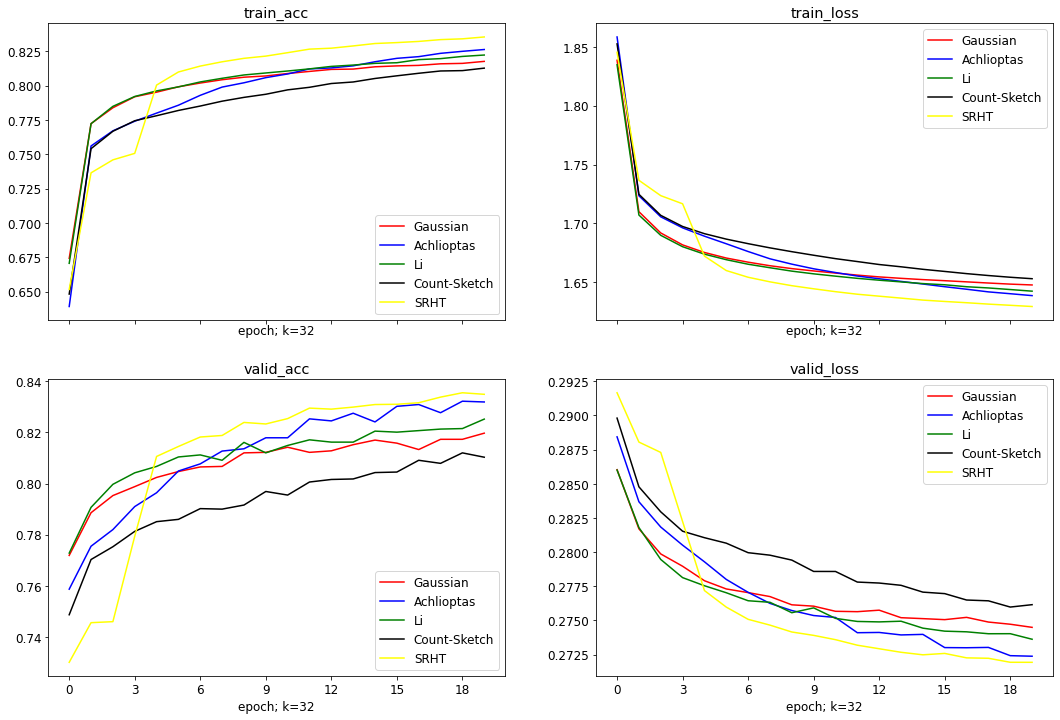

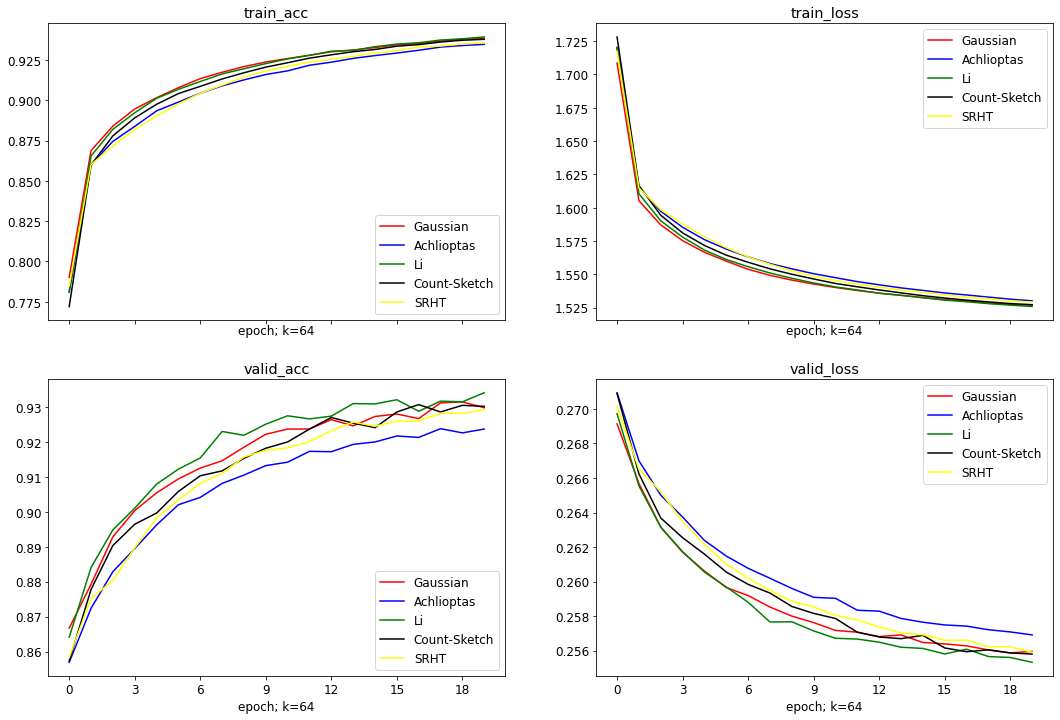

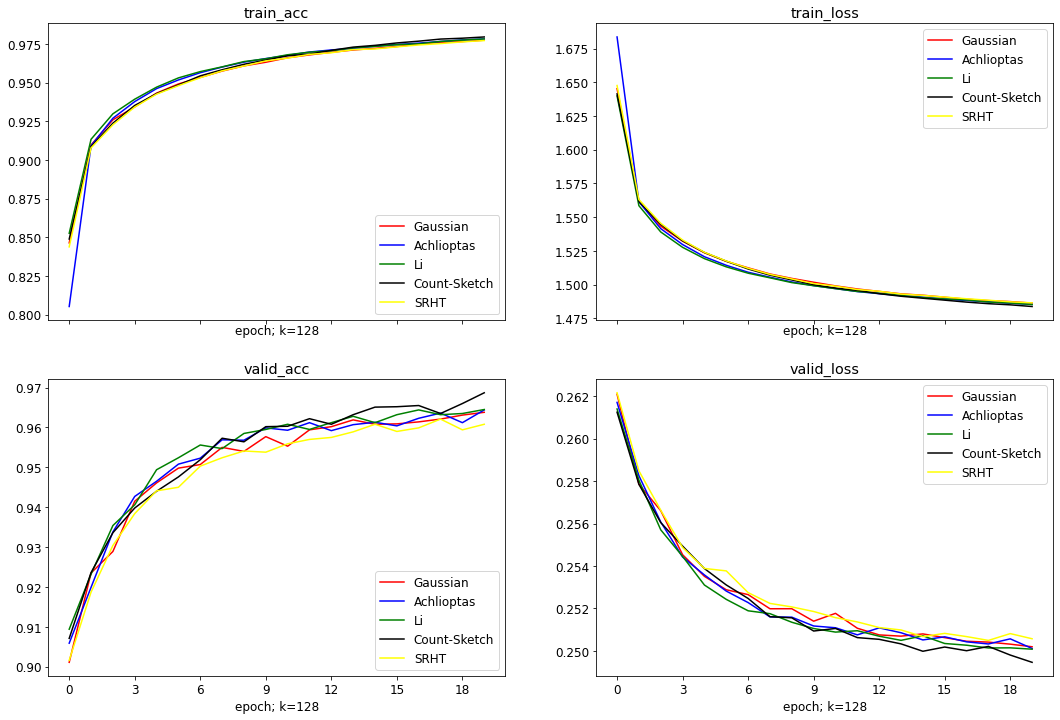

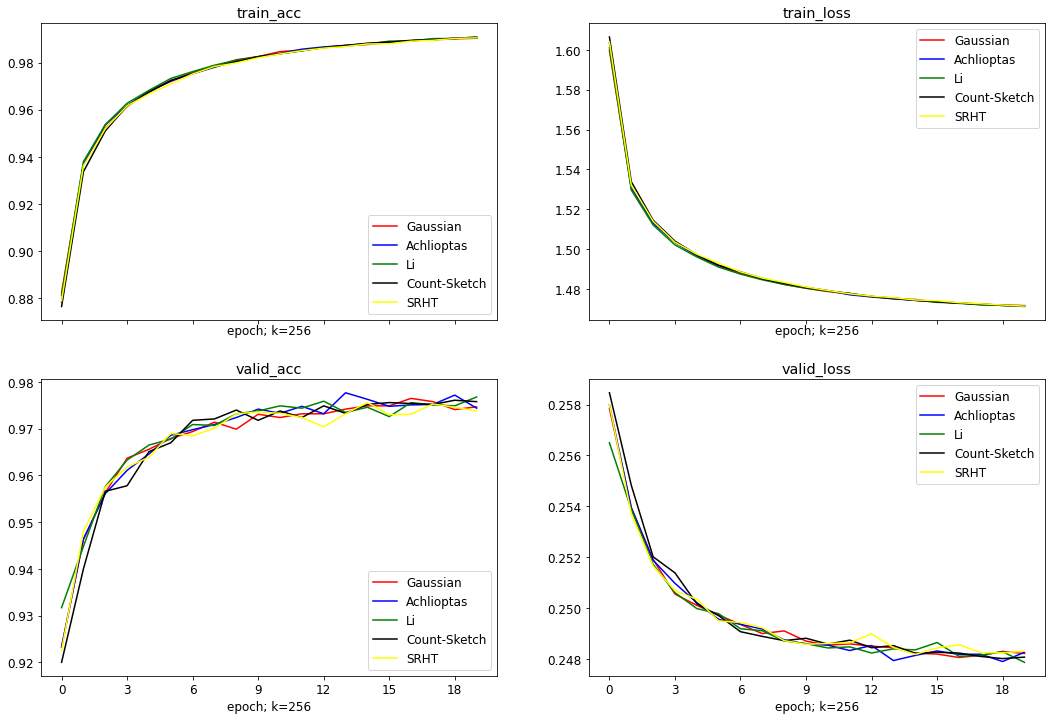

In [15]:
epochs = range(20)
for k in [32,64,128,256]:
    results_m = {'train_acc':None,'valid_acc':None,'train_loss':None,'valid_loss':None} #TODO: add SRHT
    results_m['train_acc'] = {'Gaussian':results["Gaussian"][str(k)][0],'Achlioptas':results["Achlioptas"][str(k)][0],'Li':results["Li"][str(k)][0], "Count-Sketch": results["CountSketch"][str(k)][0], "SRHT":results["SRHT"][str(k)][0]}
    results_m['valid_acc'] = {'Gaussian':results["Gaussian"][str(k)][1],'Achlioptas':results["Achlioptas"][str(k)][1],'Li':results["Li"][str(k)][1], "Count-Sketch": results["CountSketch"][str(k)][1], "SRHT":results["SRHT"][str(k)][1]}
    results_m['train_loss'] = {'Gaussian':results["Gaussian"][str(k)][2],'Achlioptas':results["Achlioptas"][str(k)][2],'Li':results["Li"][str(k)][2], "Count-Sketch": results["CountSketch"][str(k)][2], "SRHT":results["SRHT"][str(k)][2]}
    results_m['valid_loss'] = {'Gaussian':results["Gaussian"][str(k)][3],'Achlioptas':results["Achlioptas"][str(k)][3],'Li':results["Li"][str(k)][3], "Count-Sketch": results["CountSketch"][str(k)][3], "SRHT":results["SRHT"][str(k)][3]}
    plot_results(results_m, epochs, f"epoch; k={k}");


In the first graph (best accuracy to projected dimension) we can see that the difference in performance between the different methods is not major.<br/>
In the next graphs we can see clearly that for MNIST dataset, Achlioptas Random Projection performs better for a large enough amount of epochs, for a smaller number of epochs, Li's method performs better on the validation set, for a really small number of epochs we can see that the Gaussian Random Projection performs better than Achlioptas as well, Count-Sketch shows the least accuracy of all for this dataset, possibly because of the small input size (that would be tested later on a larger dataset).
A possible explanation of the results is that Li's Random Projection is similiar to Achlioptas but more sparse, this sparsity preserves less information but the information preserved is easier to learn from after very few epochs.

## Loading and training on Genetic Dataset
Now we will load and train our model on the genetic dataset

In [16]:
import dataset

genetic = dataset.gen_dataset()
gtrain, gtest = genetic.split(0.5)
genetic_train_matrix = RP.get_dataset_matrix(gtrain)
gdl_train = torch.utils.data.DataLoader(gtrain, 32, shuffle=True)
gdl_test = torch.utils.data.DataLoader(gtest, 32, shuffle=True)

In [17]:
genetic.data = genetic.data[0].reshape(801,1,20531), genetic.data[1].reshape(801,1,1) #could remove this line

Now we will train and evaluate a DNN model for this dataset

In [19]:
in_size = 20531
out_classes = 5 #maximal value was 4
lr = 1e-4
k = 400
model = FCModel(in_size=in_size, out_classes=out_classes, activation_type="relu", hidden_dims=[int(k/2),int(k/4)], rp=k, softmax=False).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss().to(device)

res = train_and_eval(model, gdl_train, gdl_test, optimizer, loss_fn, verbose=True, epochs=10)
print(f"final test accuracy:{res[1][-1]}")

Epoch #0,train loss=1.497,train accuracy=0.352, validation accuracy=0.340, elapsed=0.1 sec
*** Saved checkpoint Models/FC_RNN.pt at epoch 1
Epoch #1,train loss=1.317,train accuracy=0.410, validation accuracy=0.340, elapsed=0.1 sec
*** Saved checkpoint Models/FC_RNN.pt at epoch 2
Epoch #2,train loss=1.240,train accuracy=0.410, validation accuracy=0.340, elapsed=0.1 sec
*** Saved checkpoint Models/FC_RNN.pt at epoch 3
Epoch #3,train loss=1.145,train accuracy=0.430, validation accuracy=0.458, elapsed=0.1 sec
*** Saved checkpoint Models/FC_RNN.pt at epoch 4
Epoch #4,train loss=1.048,train accuracy=0.512, validation accuracy=0.682, elapsed=0.1 sec
*** Saved checkpoint Models/FC_RNN.pt at epoch 5
Epoch #5,train loss=0.964,train accuracy=0.738, validation accuracy=0.703, elapsed=0.1 sec
*** Saved checkpoint Models/FC_RNN.pt at epoch 6
Epoch #6,train loss=0.863,train accuracy=0.825, validation accuracy=0.925, elapsed=0.1 sec
*** Saved checkpoint Models/FC_RNN.pt at epoch 7
Epoch #7,train loss=

In [48]:
k = 2000
model = FCModel(in_size=in_size, out_classes=out_classes, activation_type="relu", hidden_dims=[int(k/2),int(k/4)], rp=k, softmax=False).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss().to(device)

res = train_and_eval(model, gdl_train, gdl_test, optimizer, loss_fn, verbose=True, epochs=10)
print(f"final test accuracy:{res[1][-1]}")

Epoch #0,train loss=1.206,train accuracy=0.542, validation accuracy=0.527, elapsed=0.1 sec
*** Saved checkpoint Models/FC_RNN.pt at epoch 1
Epoch #1,train loss=0.728,train accuracy=0.830, validation accuracy=0.958, elapsed=0.1 sec
*** Saved checkpoint Models/FC_RNN.pt at epoch 2
Epoch #2,train loss=0.383,train accuracy=0.988, validation accuracy=0.980, elapsed=0.1 sec
*** Saved checkpoint Models/FC_RNN.pt at epoch 3
Epoch #3,train loss=0.192,train accuracy=0.995, validation accuracy=0.985, elapsed=0.1 sec
*** Saved checkpoint Models/FC_RNN.pt at epoch 4
Epoch #4,train loss=0.118,train accuracy=0.995, validation accuracy=0.983, elapsed=0.1 sec
*** Saved checkpoint Models/FC_RNN.pt at epoch 5
Epoch #5,train loss=0.072,train accuracy=0.998, validation accuracy=0.993, elapsed=0.1 sec
*** Saved checkpoint Models/FC_RNN.pt at epoch 6
Epoch #6,train loss=0.048,train accuracy=1.000, validation accuracy=0.995, elapsed=0.1 sec
*** Saved checkpoint Models/FC_RNN.pt at epoch 7
Epoch #7,train loss=

We will get the result for the model without RP layers, but the rest of the architecture will remain the same

In [54]:
#same model without Random Projection layer
in_size = 20531
out_classes = 5 #maximal value was 4
lr = 1e-4
k=400
model = FCModel(in_size=in_size, out_classes=out_classes, activation_type="relu", hidden_dims=[int(k/2),int(k/4)], rp=-1, softmax=False).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss().to(device)

res = train_and_eval(model, gdl_train, gdl_test, optimizer, loss_fn, verbose=True, epochs=10)
print(f"final test accuracy:{res[1][-1]}")

Epoch #0,train loss=8.513,train accuracy=0.315, validation accuracy=0.415, elapsed=0.1 sec
*** Saved checkpoint Models/FC_RNN.pt at epoch 1
Epoch #1,train loss=2.888,train accuracy=0.485, validation accuracy=0.672, elapsed=0.1 sec
*** Saved checkpoint Models/FC_RNN.pt at epoch 2
Epoch #2,train loss=0.855,train accuracy=0.818, validation accuracy=0.905, elapsed=0.0 sec
*** Saved checkpoint Models/FC_RNN.pt at epoch 3
Epoch #3,train loss=0.169,train accuracy=0.940, validation accuracy=0.990, elapsed=0.0 sec
*** Saved checkpoint Models/FC_RNN.pt at epoch 4
Epoch #4,train loss=0.052,train accuracy=0.990, validation accuracy=0.995, elapsed=0.0 sec
*** Saved checkpoint Models/FC_RNN.pt at epoch 5
Epoch #5,train loss=0.017,train accuracy=0.998, validation accuracy=0.995, elapsed=0.0 sec
*** Saved checkpoint Models/FC_RNN.pt at epoch 6
Epoch #6,train loss=0.020,train accuracy=0.995, validation accuracy=0.995, elapsed=0.0 sec
*** Saved checkpoint Models/FC_RNN.pt at epoch 7
Epoch #7,train loss=

In [20]:
params1 = count_parameters(FCModel(in_size=in_size, out_classes=out_classes, activation_type="tanh", hidden_dims=[200,100], rp=400, softmax=False))
params2 = count_parameters(FCModel(in_size=in_size, out_classes=out_classes, activation_type="tanh", hidden_dims=[200,100], rp=-1, softmax=False))
print(f"Without RP the model has:{params2} trainable parameters, with RP to dimension 400(!) the model has {params1} trainable parameters.")

Without RP the model has:4127005 trainable parameters, with RP to dimension 400(!) the model has 101205 trainable parameters


Now we can perform the same experiments as before on our dataset

In [21]:
##Training and evaluating the results as before
A = genetic_train_matrix
U,S,V = torch.pca_lowrank(A,min(A.shape))
projections = ["Gaussian","Achlioptas", "Li", "CountSketch", "SRHT", "PCA"] 
results = {}
for proj in projections:
    if not os.path.isfile(f"Results/Genetic_RP_{proj}.txt"):
        continue
    file = open(f"Results/Genetic_RP_{proj}.txt","r+")
    results[proj] = json.loads(file.read())
    file.close()
#Training RP types that were not trained before
krange = list(torch.logspace(5,12,8,base=2))[::-1] #we test k's from 32 to 4096 with multiplicative steps of 2
in_size = 20531
out_classes = 5 #maximal value was 4
lr = 1e-4
padding = 0
for proj in projections:
    if proj in results.keys(): #We would not retrain any model alreay trained (if krange list changed we would want to retrain)
        print(f"loaded for {proj}")
        continue
    results[proj] = {}
    print(f"training for {proj}")
    if proj == "SRHT":
        padding = 2**15 - in_size #TODO: make this line adaptive in input_size
    else:
        padding = 0
    for k in list(krange)[::1]:
        if device.type == 'cuda':
            torch.cuda.empty_cache()
        if proj == "PCA":
            g_model = FCModel(in_size=in_size, out_classes=num_classes, activation_type="relu", hidden_dims=[int(k/2)], rp=-1, rp_type=proj, padding=padding, softmax=False, pca=V[:,:int(k)].T).to(device)
        else:    
            g_model = FCModel(in_size=in_size, out_classes=num_classes, activation_type="relu", hidden_dims=[int(k/2)], rp=int(k), rp_type=proj, padding=padding, softmax=False).to(device)
        print(f"projected dimension:{int(k)}")
        #print(f"Model Architecture:{mnist_model}")
        
        optimizer = torch.optim.Adam(g_model.parameters(), lr=lr)
        loss_fn = nn.CrossEntropyLoss().to(device)

        res = train_and_eval(g_model, gdl_train, gdl_test, optimizer, loss_fn, verbose=False, epochs=10) #TODO: change verbose to false
        print(f'accuracy:{res[0], res[1]}')
        results[proj][str(int(k))] = res
    Save_Results(results[proj], proj, dataset="Genetic")
        

loaded for Gaussian
loaded for Achlioptas
loaded for Li
loaded for CountSketch
loaded for SRHT
loaded for PCA


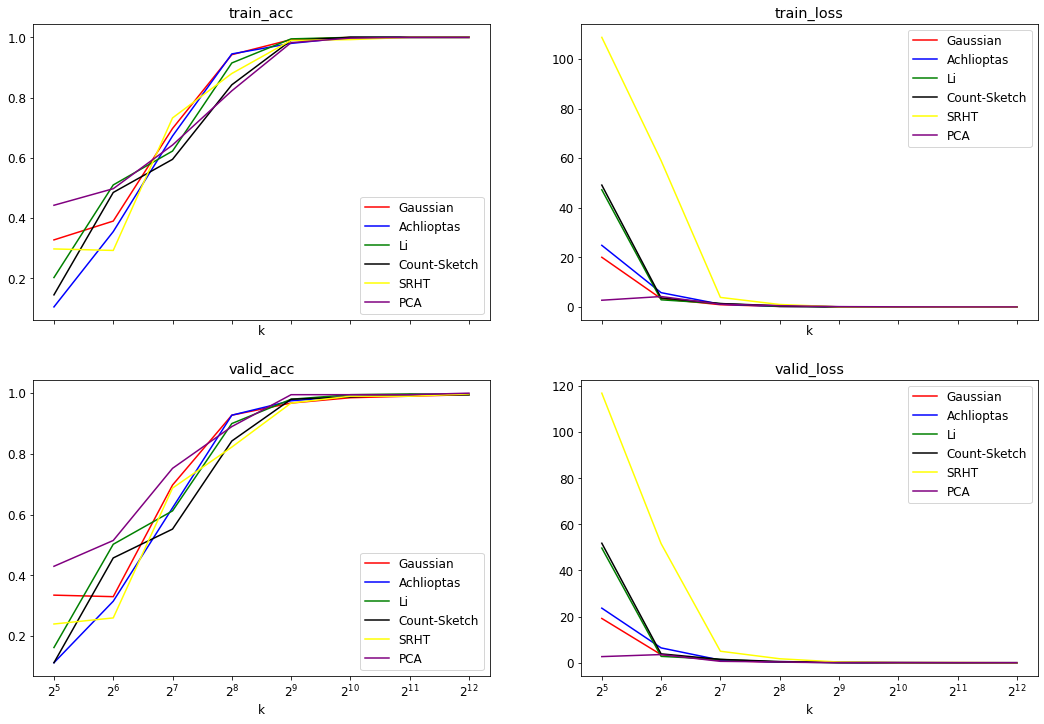

In [23]:
final = {}
for proj in (results.keys()):
    final[proj] = {}
    for k in list(results[proj].keys())[::-1]:
        for i in range(4): # 4 different measurements of accuracy/loss
            temp = max(results[proj][k][i]) if i <= 1 else min(results[proj][k][i])
            if i in final[proj].keys():
                final[proj][i].append(temp)
            else:
                final[proj][i] = [temp]
            
krange = list(torch.logspace(5,12,8,base=2))

results_m = {'train_acc':None,'valid_acc':None,'train_loss':None,'valid_loss':None}
#graph without PCA
##results_m['train_acc'] = {'Gaussian':final["Gaussian"][0],'Achlioptas':final["Achlioptas"][0],'Li':final["Li"][0], "Count-Sketch": final["CountSketch"][0], "SRHT": final["SRHT"][0]}
##results_m['valid_acc'] = {'Gaussian':final["Gaussian"][1],'Achlioptas':final["Achlioptas"][1],'Li':final["Li"][1], "Count-Sketch": final["CountSketch"][1], "SRHT": final["SRHT"][1]}
##results_m['train_loss'] = {'Gaussian':final["Gaussian"][2],'Achlioptas':final["Achlioptas"][2],'Li':final["Li"][2], "Count-Sketch": final["CountSketch"][2], "SRHT": final["SRHT"][2]}
##results_m['valid_loss'] = {'Gaussian':final["Gaussian"][3],'Achlioptas':final["Achlioptas"][3],'Li':final["Li"][3], "Count-Sketch": final["CountSketch"][3], "SRHT": final["SRHT"][3]}
#graph with PCA
results_m['train_acc'] = {'Gaussian':final["Gaussian"][0],'Achlioptas':final["Achlioptas"][0],'Li':final["Li"][0], "Count-Sketch": final["CountSketch"][0], "SRHT": final["SRHT"][0],"PCA":final["PCA"][0]}
results_m['valid_acc'] = {'Gaussian':final["Gaussian"][1],'Achlioptas':final["Achlioptas"][1],'Li':final["Li"][1], "Count-Sketch": final["CountSketch"][1], "SRHT": final["SRHT"][1],"PCA":final["PCA"][1]}
results_m['train_loss'] = {'Gaussian':final["Gaussian"][2],'Achlioptas':final["Achlioptas"][2],'Li':final["Li"][2], "Count-Sketch": final["CountSketch"][2], "SRHT": final["SRHT"][2],"PCA":final["PCA"][2]}
results_m['valid_loss'] = {'Gaussian':final["Gaussian"][3],'Achlioptas':final["Achlioptas"][3],'Li':final["Li"][3], "Count-Sketch": final["CountSketch"][3], "SRHT": final["SRHT"][3],"PCA":final["PCA"][3]}
plot_results(results_m, krange, xscale="log", xbase=2.0);

We would want to focus more between: ${2^5- 2^8}$

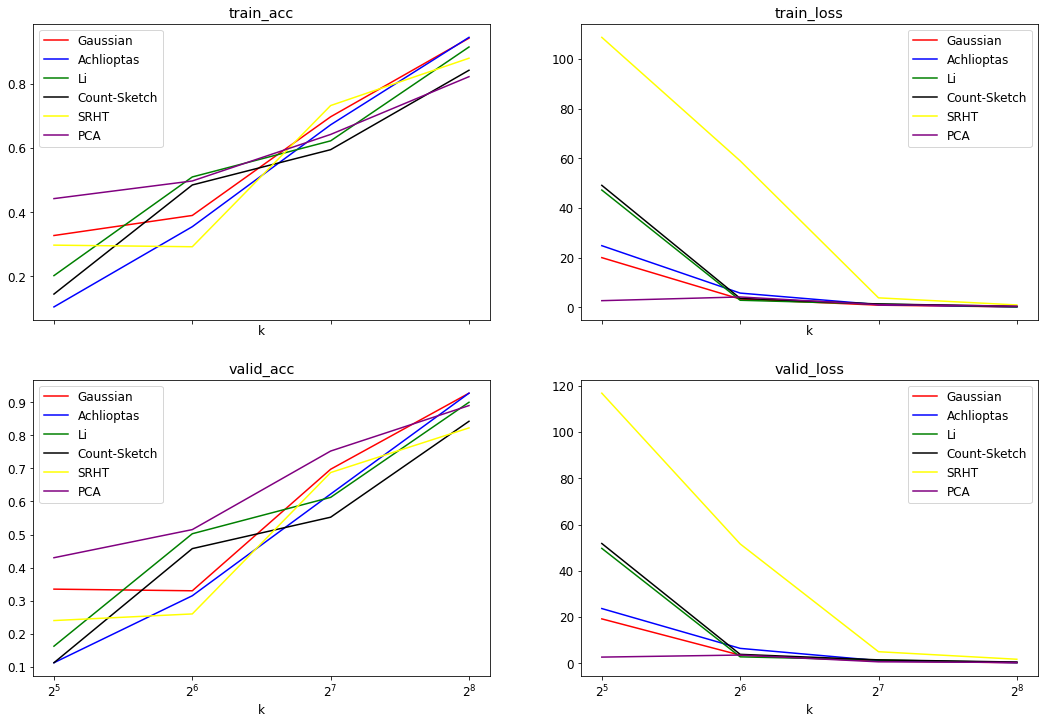

In [25]:
final = {}
for proj in (results.keys()):
    final[proj] = {}
    for k in list(results[proj].keys())[::-1][:4]:
        for i in range(4): # 4 different measurements of accuracy/loss
            temp = max(results[proj][k][i]) if i <= 1 else min(results[proj][k][i])
            if i in final[proj].keys():
                final[proj][i].append(temp)
            else:
                final[proj][i] = [temp]
            
krange = list(torch.logspace(5,12,8,base=2))[:4]

#graph without PCA
##results_m['train_acc'] = {'Gaussian':final["Gaussian"][0],'Achlioptas':final["Achlioptas"][0],'Li':final["Li"][0], "Count-Sketch": final["CountSketch"][0], "SRHT": final["SRHT"][0]}
##results_m['valid_acc'] = {'Gaussian':final["Gaussian"][1],'Achlioptas':final["Achlioptas"][1],'Li':final["Li"][1], "Count-Sketch": final["CountSketch"][1], "SRHT": final["SRHT"][1]}
##results_m['train_loss'] = {'Gaussian':final["Gaussian"][2],'Achlioptas':final["Achlioptas"][2],'Li':final["Li"][2], "Count-Sketch": final["CountSketch"][2], "SRHT": final["SRHT"][2]}
##results_m['valid_loss'] = {'Gaussian':final["Gaussian"][3],'Achlioptas':final["Achlioptas"][3],'Li':final["Li"][3], "Count-Sketch": final["CountSketch"][3], "SRHT": final["SRHT"][3]}
#graph with PCA
results_m['train_acc'] = {'Gaussian':final["Gaussian"][0],'Achlioptas':final["Achlioptas"][0],'Li':final["Li"][0], "Count-Sketch": final["CountSketch"][0], "SRHT": final["SRHT"][0],"PCA":final["PCA"][0]}
results_m['valid_acc'] = {'Gaussian':final["Gaussian"][1],'Achlioptas':final["Achlioptas"][1],'Li':final["Li"][1], "Count-Sketch": final["CountSketch"][1], "SRHT": final["SRHT"][1],"PCA":final["PCA"][1]}
results_m['train_loss'] = {'Gaussian':final["Gaussian"][2],'Achlioptas':final["Achlioptas"][2],'Li':final["Li"][2], "Count-Sketch": final["CountSketch"][2], "SRHT": final["SRHT"][2],"PCA":final["PCA"][2]}
results_m['valid_loss'] = {'Gaussian':final["Gaussian"][3],'Achlioptas':final["Achlioptas"][3],'Li':final["Li"][3], "Count-Sketch": final["CountSketch"][3], "SRHT": final["SRHT"][3],"PCA":final["PCA"][3]}
plot_results(results_m, krange, xscale="log", xbase=2.0);

We see that for larger projected dimension, Gaussian and Achlioptas generally perform better than other RP models.<br/>
We can also see that for smaller projected dimensions, Li and Count-Sketch perform better than most other models, SRHT/FJLT seems to perform competitvely mostly at larger projected dimensions, that could be improved by changing the density argument of the projection ${(q)}$.
We can see that Random Projection methods are comparable for this dataset to the PCA method (PCA over the training set only) and in for certain k values Achlioptas and Gaussian are even achieving slightly better results, this can be explained by the small size of the datset which causes the PCA method to overfit the training set and not to fit percisely for all of the dataset, also since the original dimensions are very high, the RP layers achieve good results in comparison to the PCA dimensionality reduction and achieve optimal solution for 20 times dimensionality reduction (from 20531 to 1024)

In [26]:
#We will save the results from these models for later comparison
old_results = results

## Deeper Models
Now we would examine a model with three hidden layers

In [32]:
##Training and evaluating the results as before
#projections = ["Gaussian","Achlioptas", "Li", "CountSketch", "SRHT"] 
results = {}
for proj in projections:
    if not os.path.isfile(f"Results/GeneticDeeper_RP_{proj}.txt"):
        continue
    file = open(f"Results/GeneticDeeper_RP_{proj}.txt","r+")
    results[proj] = json.loads(file.read())
    file.close()
#Training RP types that were not trained before
krange = list(torch.logspace(5,12,8,base=2))[::-1] #we test k's from 32 to 4096 with multiplicative steps of 2
in_size = 20531
out_classes = 5 #maximal value was 4
lr = 1e-4
padding = 0
for proj in projections:
    if proj in results.keys(): #We would not retrain any model alreay trained (if krange list changed we would want to retrain)
        print(f"loaded for {proj}")
        continue
    results[proj] = {}
    print(f"training for {proj}")
    if proj == "SRHT":
        padding = 2**15 - in_size #TODO: make this line adaptive in input_size
    else:
        padding = 0
    for k in list(krange)[::1]:
        if device.type == 'cuda':
            torch.cuda.empty_cache()
        if proj == "PCA":
            g_model = FCModel(in_size=in_size, out_classes=num_classes, activation_type="relu", hidden_dims=[int(k/2),int(k/4),int(k/8)], rp=-1, rp_type=proj, padding=padding, softmax=False, pca=V[:,:int(k)].T).to(device)
        else:    
            g_model = FCModel(in_size=in_size, out_classes=num_classes, activation_type="relu", hidden_dims=[int(k/2),int(k/4),int(k/8)], rp=int(k), rp_type=proj, padding=padding, softmax=False).to(device)
        print(f"projected dimension:{int(k)}")
        #print(f"Model Architecture:{mnist_model}")
        
        optimizer = torch.optim.Adam(g_model.parameters(), lr=lr)
        loss_fn = nn.CrossEntropyLoss().to(device)

        res = train_and_eval(g_model, gdl_train, gdl_test, optimizer, loss_fn, verbose=False, epochs=10) #TODO: change verbose to false
        print(f'accuracy:{res[0], res[1]}')
        results[proj][str(int(k))] = res
    Save_Results(results[proj], proj, dataset="GeneticDeeper")

loaded for Gaussian
loaded for Achlioptas
loaded for Li
loaded for CountSketch
loaded for SRHT
loaded for PCA


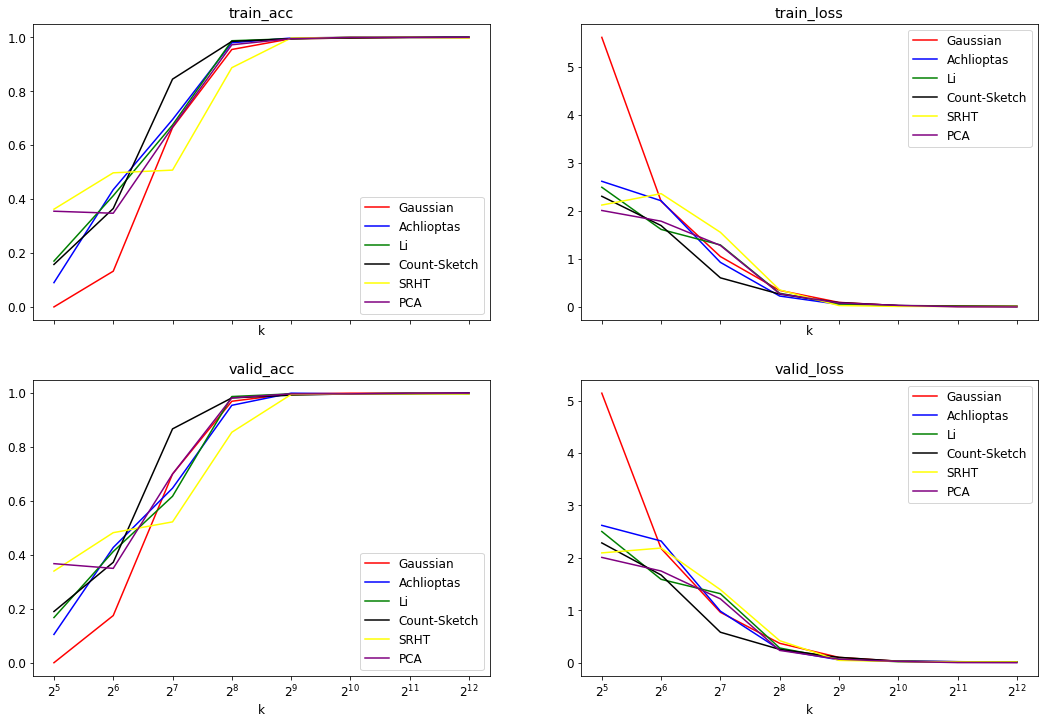

In [46]:
final = {}
for proj in (results.keys()):
    final[proj] = {}
    if proj == "PCA":
        order = -1
    else:
        order = 1
    for k in list(results[proj].keys())[::order]:
        for i in range(4): # 4 different measurements of accuracy/loss
            temp = max(results[proj][k][i]) if i <= 1 else min(results[proj][k][i])
            if i in final[proj].keys():
                final[proj][i].append(temp)
            else:
                final[proj][i] = [temp]
            
krange = list(torch.logspace(5,12,8,base=2))

#graph without PCA
##results_m['train_acc'] = {'Gaussian':final["Gaussian"][0],'Achlioptas':final["Achlioptas"][0],'Li':final["Li"][0], "Count-Sketch": final["CountSketch"][0], "SRHT": final["SRHT"][0]}
##results_m['valid_acc'] = {'Gaussian':final["Gaussian"][1],'Achlioptas':final["Achlioptas"][1],'Li':final["Li"][1], "Count-Sketch": final["CountSketch"][1], "SRHT": final["SRHT"][1]}
##results_m['train_loss'] = {'Gaussian':final["Gaussian"][2],'Achlioptas':final["Achlioptas"][2],'Li':final["Li"][2], "Count-Sketch": final["CountSketch"][2], "SRHT": final["SRHT"][2]}
##results_m['valid_loss'] = {'Gaussian':final["Gaussian"][3],'Achlioptas':final["Achlioptas"][3],'Li':final["Li"][3], "Count-Sketch": final["CountSketch"][3], "SRHT": final["SRHT"][3]}
#graph with PCA
results_m['train_acc'] = {'Gaussian':final["Gaussian"][0],'Achlioptas':final["Achlioptas"][0],'Li':final["Li"][0], "Count-Sketch": final["CountSketch"][0], "SRHT": final["SRHT"][0],"PCA":final["PCA"][0]}
results_m['valid_acc'] = {'Gaussian':final["Gaussian"][1],'Achlioptas':final["Achlioptas"][1],'Li':final["Li"][1], "Count-Sketch": final["CountSketch"][1], "SRHT": final["SRHT"][1],"PCA":final["PCA"][1]}
results_m['train_loss'] = {'Gaussian':final["Gaussian"][2],'Achlioptas':final["Achlioptas"][2],'Li':final["Li"][2], "Count-Sketch": final["CountSketch"][2], "SRHT": final["SRHT"][2],"PCA":final["PCA"][2]}
results_m['valid_loss'] = {'Gaussian':final["Gaussian"][3],'Achlioptas':final["Achlioptas"][3],'Li':final["Li"][3], "Count-Sketch": final["CountSketch"][3], "SRHT": final["SRHT"][3],"PCA":final["PCA"][3]}

plot_results(results_m, krange, xscale="log", xbase=2.0);

As before, we would focus more between: ${2^5- 2^8}$

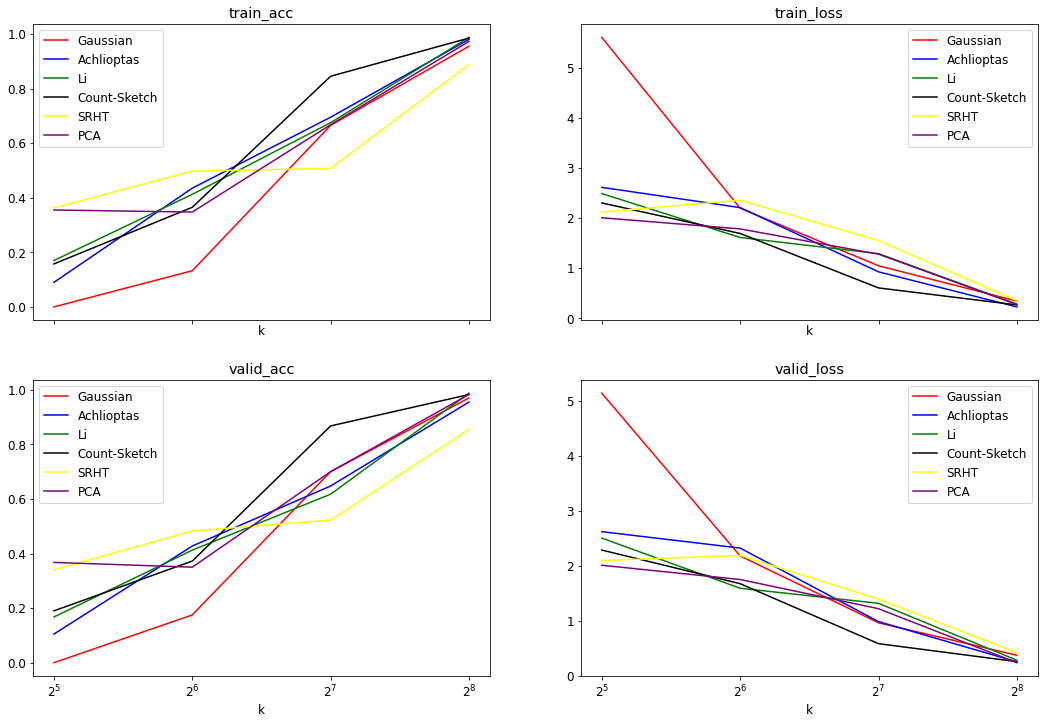

In [47]:
final = {}
for proj in (results.keys()):
    final[proj] = {}
    if proj == "PCA":
        order = -1
    else:
        order = 1
    for k in list(results[proj].keys())[::order][:4]:
        for i in range(4): # 4 different measurements of accuracy/loss
            temp = max(results[proj][k][i]) if i <= 1 else min(results[proj][k][i])
            if i in final[proj].keys():
                final[proj][i].append(temp)
            else:
                final[proj][i] = [temp]
            
krange = list(torch.logspace(5,12,8,base=2))[:4]

#graph without PCA
##results_m['train_acc'] = {'Gaussian':final["Gaussian"][0],'Achlioptas':final["Achlioptas"][0],'Li':final["Li"][0], "Count-Sketch": final["CountSketch"][0], "SRHT": final["SRHT"][0]}
##results_m['valid_acc'] = {'Gaussian':final["Gaussian"][1],'Achlioptas':final["Achlioptas"][1],'Li':final["Li"][1], "Count-Sketch": final["CountSketch"][1], "SRHT": final["SRHT"][1]}
##results_m['train_loss'] = {'Gaussian':final["Gaussian"][2],'Achlioptas':final["Achlioptas"][2],'Li':final["Li"][2], "Count-Sketch": final["CountSketch"][2], "SRHT": final["SRHT"][2]}
##results_m['valid_loss'] = {'Gaussian':final["Gaussian"][3],'Achlioptas':final["Achlioptas"][3],'Li':final["Li"][3], "Count-Sketch": final["CountSketch"][3], "SRHT": final["SRHT"][3]}
#graph with PCA
results_m['train_acc'] = {'Gaussian':final["Gaussian"][0],'Achlioptas':final["Achlioptas"][0],'Li':final["Li"][0], "Count-Sketch": final["CountSketch"][0], "SRHT": final["SRHT"][0],"PCA":final["PCA"][0]}
results_m['valid_acc'] = {'Gaussian':final["Gaussian"][1],'Achlioptas':final["Achlioptas"][1],'Li':final["Li"][1], "Count-Sketch": final["CountSketch"][1], "SRHT": final["SRHT"][1],"PCA":final["PCA"][1]}
results_m['train_loss'] = {'Gaussian':final["Gaussian"][2],'Achlioptas':final["Achlioptas"][2],'Li':final["Li"][2], "Count-Sketch": final["CountSketch"][2], "SRHT": final["SRHT"][2],"PCA":final["PCA"][2]}
results_m['valid_loss'] = {'Gaussian':final["Gaussian"][3],'Achlioptas':final["Achlioptas"][3],'Li':final["Li"][3], "Count-Sketch": final["CountSketch"][3], "SRHT": final["SRHT"][3],"PCA":final["PCA"][3]}
plot_results(results_m, krange, xscale="log", xbase=2.0);

**Parameters Count**

tensor([       77,     14141,     53112,    117238,    205799,    320083,
           458759,    622935,    809538,   1022735,   1262046,   1525147,
          1813347,   2126249,   2465748,   2828554,   3212381,   3626198,
          4063525,   4528051,   5013900,   5527767,   6064799,   6621165,
          7210649,   7822236,   8460958,   9120551,   9810223,  10521515,
         11260287,  12013962,  12799775,  13614474,  14450191,  15311403,
         16196921,  17111808,  18047230,  18998129,  19986542,  20996485,
         22036399,  23093280,  24181743,  25291391,  26414829,  27579701,
         28763904,  29977222,  31207847,  32472907,  33756815,  35070183,
         36390930,  37749359,  39139446,  40547779,  41982003,  43440137,
         44930412,  46438450,  47956421,  49519430,  51101989,  52712810,
         54345204,  56008263,  57690527,  59381037,  61121297,  62878116,
         64666030,  66467687,  68308135,  70164659,  72052623,  73940442,
         75871487,  77836962,  7981791

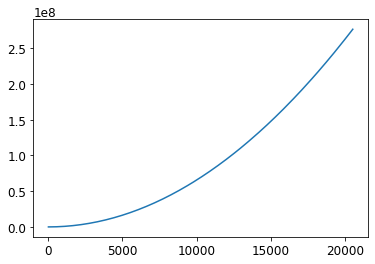

In [20]:
krange = torch.linspace(8,20531,150)
params = []
for k in krange:
    g_model = FCModel(in_size=in_size, out_classes=num_classes, activation_type="relu", hidden_dims=[int(k/2),int(k/4),int(k/8)], rp=int(k), rp_type="Gaussian", padding=0, softmax=False).to(device)
    params.append(count_parameters(g_model))
print(torch.tensor(params))
plt.plot(np.array(krange), params)

In [ ]:
#again we will present stats and confusion matrix for several different k values
kvalues = [128,256,512]
for k in kvalues:
    model = FCModel(in_size=20531, out_classes=5, activation_type="relu", hidden_dims=[int(k/2),int(k/4),int(k/8)], rp=int(k), rp_type="CountSketch", padding=0).to(device)
    lr = 1e-4
    optimizer = torch.optim.Adam(mnist_model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss().to(device)

    res = train_and_eval(mnist_model, mdl_train, mdl_test, optimizer, loss_fn, verbose=False)
    
    present_accuracy(model, mdl_test, classes=5)
    print_stats(model, mdl_test, classes=5)

In [39]:
print(max(results["PCA"]["128"][1]))
print(final["PCA"][1])

0.7
[1.0, 1.0, 0.9975, 0.9975]


## Loading and training on the Hydraulic dataset
Next, we would load the given hydraulic dataset, it has 2205 examples with 43680 attributes each, it fits for a 5 different classification problems and we would train it on classification problems.<br/>
We will split the dataset to training and test sets where training set and test set are roughly equal. **Note: this ratio could change by changing split function parameters**

In [106]:
Hydraulic = dataset.dataset(classification=1)#files_to_ignore=["dataset.py", "description.txt","documentation.txt", "__pycache__","PS1.txt","PS2.txt","PS3.txt","PS4.txt","PS5.txt","PS6.txt","TS1.txt","TS2.txt","EPS1.txt"])
Hydraulic.fit_classification() #for classification we would use integer class labels
Hydraulic.to_type(torch.int64)
htrain, htest = Hydraulic.split(0.6)
hdl_train = torch.utils.data.DataLoader(htrain, 32, shuffle=True)
hdl_test = torch.utils.data.DataLoader(htest, 32, shuffle=True)

loading file: CE.txt
loading file: CP.txt
loading file: EPS1.txt
loading file: FS1.txt
loading file: FS2.txt
loading file: PS1.txt
loading file: PS2.txt
loading file: PS3.txt
loading file: PS4.txt
loading file: PS5.txt
loading file: PS6.txt
loading file: SE.txt
loading file: TS1.txt
loading file: TS2.txt
loading file: TS3.txt
loading file: TS4.txt
loading file: VS1.txt


/home/shai.kimhi/deepAccel/rp-nn/dataset.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.data = self.data[0], torch.tensor(self.data[1], dtype=data_type)


In [123]:
print(max(htest.data[1].T[1]))
print(htrain.data[0].shape)

tensor(3)
torch.Size([1323, 43680])


In [115]:
count_parameters(h_model)

174724

In [121]:
Hydraulic.class_num = 4
Hydraulic.fit_classification() #for classification we would use integer class labels
Hydraulic.to_type(torch.int64)
htrain, htest = Hydraulic.split(0.6)
hdl_train = torch.utils.data.DataLoader(htrain, 32, shuffle=True)
hdl_test = torch.utils.data.DataLoader(htest, 32, shuffle=True)

In [ ]:
in_size = 43680
out_classes = 1 #maximal value was 3
lr = 1e-3
k = 400
model = FCModel(in_size=in_size, out_classes=out_classes, activation_type="tanh", hidden_dims=[1000,400], rp=4000, softmax=False).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss().to(device)

res = train_and_eval(model, hdl_train, hdl_test, optimizer, loss_fn, verbose=True, epochs=10)
print(f"final test accuracy:{res[1][-1]}")

In [ ]:
#check num of classes for classification problem
values = []
for i in range(2205):
    if Hydraulic[i][1] not in values:
        values.append(Hydraulic[i][1])
values

Now we will repeat the training and evaluations that we have done before

In [ ]:
##Training and evaluating the results as before
projections = ["Gaussian","Achlioptas", "Li", "CountSketch", "SRHT"] #TODO: add SRHT, needs to add zero paddings to dataset
results = {}
for proj in projections:
    if not os.path.isfile(f"Results/Hydraulic_RP_{proj}.txt"):
        continue
    file = open(f"Results/Hydraulic_RP_{proj}.txt","r+")
    results[proj] = json.loads(file.read())
    file.close()
#Training RP types that were not trained before
in_size = 43680
num_classes = len(values)
lr = 1e-4
krange = list(torch.logspace(5,12,8,base=2))[::-1] #we test k's from 1 to 784 with multiplicative steps of 2
padding = 0
for proj in projections:
    if proj in results.keys(): #We would not retrain any model alreay trained (if krange list changed we would want to retrain)
        continue
    results[proj] = {}
    print(f"training for {proj}")
    if proj == "SRHT":
        padding = 2**16 - in_size #TODO: make this line adaptive in input_size
    for k in list(krange)[::1]:
        if device.type == 'cuda':
            torch.cuda.empty_cache()
        h_model = FCModel(in_size=in_size, out_classes=num_classes, activation_type="relu", hidden_dims=[int(k/2)], rp=int(k), rp_type=proj, padding=padding, softmax=False).to(device)
        print(f"projected dimension:{int(k)}")
        #print(f"Model Architecture:{mnist_model}")
        
        optimizer = torch.optim.Adam(h_model.parameters(), lr=lr)
        loss_fn = nn.CrossEntropyLoss().to(device)

        res = train_and_eval(h_model, hdl_train, hdl_test, optimizer, loss_fn, verbose=True) #TODO: change verbose to false
        #print(f'accuracy:{res[0], res[1]}')
        results[proj][str(int(k))] = res
        
for proj in projections:
    print(proj)
    Save_Results(results[proj], proj, dataset="Hydraulic")

## CIFAR-10

In [6]:
#CIFAR-10 DOWNLOAD
data_dir = os.path.expanduser('~/.pytorch-datasets')
cifar10_train = torchvision.datasets.CIFAR10(root=data_dir, download=True, train=True, transform=tvtf.ToTensor())
cifar10_test = torchvision.datasets.CIFAR10(root=data_dir, download=True, train=False, transform=tvtf.ToTensor())

cifar_train_matrix = RP.get_dataset_matrix(cifar10_train)
cdl_train = torch.utils.data.DataLoader(cifar10_train, batch_size, shuffle=True)
cdl_test = dl_train = torch.utils.data.DataLoader(cifar10_test, batch_size, shuffle=True)

print(f'Train: {len(cifar10_train)} samples')
print(f'Test: {len(cifar10_test)} samples')

x0,y0 = cifar10_train[0]
in_size = x0.shape
num_classes = 10
print('CIFAR-10 input image size =', in_size)


Files already downloaded and verified
Files already downloaded and verified
Train: 50000 samples
Test: 10000 samples
CIFAR-10 input image size = torch.Size([3, 32, 32])


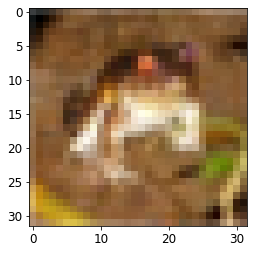

In [7]:
plt.imshow(x0.permute(1,2,0))

In [8]:
batch_size

32

In [ ]:
#we will test model with and without RP layers
in_size = x0.shape[0]*x0.shape[1]*x0.shape[2]
out_classes = 10
lr = 5e-4
k = 400
model = FCModel(in_size=in_size, out_classes=out_classes, activation_type="relu", hidden_dims=[int(k/2),int(k/4),int(k/8)], rp=k, softmax=True).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss().to(device)

res = train_and_eval(model, cdl_train, cdl_test, optimizer, loss_fn, verbose=True, epochs=10)
print(f"final test accuracy:{res[1][-1]}")

In [10]:
A = cifar_train_matrix
U,S,V = torch.pca_lowrank(A,min(A.shape))

In [11]:
##Training and evaluating the results as before

projections = ["Gaussian","Achlioptas", "Li", "CountSketch", "SRHT", "PCA"] 
results = {}
for proj in projections:
    if not os.path.isfile(f"Results/CIFAR_RP_{proj}.txt"):
        continue
    file = open(f"Results/CIFAR_RP_{proj}.txt","r+")
    results[proj] = json.loads(file.read())
    file.close()
#Training RP types that were not trained before
krange = [32,64,128,256,512,1024,2048] #we test k's from 32 to 4096 with multiplicative steps of 2
in_size = in_size
out_classes = 10
lr = 1e-3
padding = 0
for proj in projections:
    if proj in results.keys(): #We would not retrain any model alreay trained (if krange list changed we would want to retrain)
        print(f"loaded for {proj}")
        continue
    results[proj] = {}
    print(f"training for {proj}")
    if proj == "SRHT":
        padding = 2**15 - in_size #TODO: make this line adaptive in input_size
    else:
        padding = 0
    for k in list(krange)[::1]:
        if device.type == 'cuda':
            torch.cuda.empty_cache()
        if proj == "PCA":
            g_model = FCModel(in_size=in_size, out_classes=num_classes, activation_type="relu", hidden_dims=[int(k/2),int(k/4),int(k/8)], rp=-1, rp_type=proj, padding=padding, softmax=False, pca=V[:,:int(k)].T).to(device)
        else:    
            g_model = FCModel(in_size=in_size, out_classes=num_classes, activation_type="relu", hidden_dims=[int(k/2),int(k/4),int(k/8)], rp=int(k), rp_type=proj, padding=padding, softmax=False).to(device)
        print(f"projected dimension:{int(k)}")
        #print(f"Model Architecture:{mnist_model}")
        
        optimizer = torch.optim.Adam(g_model.parameters(), lr=lr)
        loss_fn = nn.CrossEntropyLoss().to(device)

        res = train_and_eval(g_model, cdl_train, cdl_test, optimizer, loss_fn, verbose=False, epochs=10) #TODO: change verbose to false
        print(f'accuracy:{res[0], res[1]}')
        results[proj][str(int(k))] = res
    Save_Results(results[proj], proj, dataset="CIFAR")

loaded for Gaussian
loaded for Achlioptas
loaded for Li
loaded for CountSketch
loaded for SRHT
loaded for PCA
